In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
def first_not_nan(series):
    s = series.dropna()
    return s.iloc[0] if len(s) > 0 else pd.NA


In [90]:
"""from list_files import list_files
from read_transcription import *
from normalise_text import *
tg_to_wav = list_files("/vol/corpora/Rhapsodie/TextGrids-fev2013")
ref = []
utt_ids=[]
for tg,wav in tg_to_wav.items():
    wav_file = os.path.join("/vol/corpora/Rhapsodie/wav16k_corrected", wav)
    trans_file = os.path.join("/vol/corpora/Rhapsodie/TextGrids-fev2013", tg)
    if os.path.exists(wav_file) and os.path.exists(trans_file):
        utt_ids.append(wav.split(".")[0])
        ref_transcriptions = get_textgrid_transcription_rhap(trans_file)
        ref.append(" ".join(normalization(ref_transcriptions)))"""

In [91]:
"""def create_ref_trn(ref_texts, utt_ids, output_path="ref.trn"):
    assert len(ref_texts) == len(utt_ids), "Mismatch texts / utt_ids"

    with open(output_path, "w", encoding="utf-8") as f:
        for text, utt_id in zip(ref_texts, utt_ids):
            text = text.strip().lower()
            f.write(f"{text} ({utt_id})\n")
create_ref_trn(ref, utt_ids, "ref.trn")"""

In [53]:
df =pd.read_csv("/vol/experiments3/imbenamor/TAPAS-FRAIS/logs/csv_files/rhap/rhap_sans_hesitation.csv")


In [58]:
import ast

def str_to_list(s):
    try:
        out = ast.literal_eval(s)
        return out if isinstance(out, list) else []
    except (ValueError, SyntaxError):
        return []


In [98]:
#df.drop(df.index[12], inplace=True)
#df.drop(df.index[34], inplace=True)
def dataframe_to_trn(
    df,
    text_col,
    utt_id_col,
    output_path
):
    """
    Convert a dataframe with token lists into a TRN file for sclite
    """
    with open(output_path, "w", encoding="utf-8") as f:
        for _, row in df.iterrows():
            words = str_to_list(row[text_col])
            utt_id = row[utt_id_col].split(".")[0]

            # sécurité : vérifier que c'est bien une liste
            if not isinstance(words, list):
                continue

            sentence = " ".join(words)
            f.write(f"{sentence} ({utt_id})\n")


In [113]:
dataframe_to_trn(
    df=df,
    text_col="trans_hmm_tdnn_vad_chunk",
    utt_id_col="filename",
    output_path="hyp_hmmtdnn.trn"
)

In [114]:
!/home/rouas/Sources/git/kaldi/tools/sctk/bin/sclite \
  -r ref.trn trn \
  -h hyp_hmmtdnn.trn trn \
  -i rm \
  -o pralign

sclite: 2.10 TK Version 1.3
Begin alignment of Ref File: 'ref.trn' and Hyp File: 'hyp_hmmtdnn.trn'
    Alignment# 54 for speaker rhap          

    Writing string alignments to 'hyp_hmmtdnn.trn.pra'

Successful Completion


In [197]:
import re

import re

def extract_del_sub_from_pra_yours(pra_path):
    deletions = []
    substitutions = []

    with open(pra_path, encoding="utf-8") as f:
        ref_words = hyp_words = None

        for line in f:
            if line.startswith("REF:"):
                ref_words = line.replace("REF:", "").split()

            elif line.startswith("HYP:"):
                hyp_words = line.replace("HYP:", "").split()

            elif line.startswith("Eval:") and ref_words and hyp_words:
                r_i = 0
                h_i = 0

                while r_i < len(ref_words) and h_i < len(hyp_words):
                    hyp_tok = hyp_words[h_i]
                    ref_tok = ref_words[r_i]

                    # Deletion: hyp is stars
                    if re.fullmatch(r"\*+", hyp_tok):
                        deletions.append(ref_tok)
                        r_i += 1
                        h_i += 1

                    # Substitution: different real words
                    elif hyp_tok != ref_tok:
                        substitutions.append(ref_tok)
                        r_i += 1
                        h_i += 1

                    # Correc
                    else:
                        r_i += 1
                        h_i += 1

    return deletions, substitutions

del_words_conf, sub_words =  extract_del_sub_from_pra_yours("hyp_confester.trn.pra")
del_words_whisp_large, sub_words =  extract_del_sub_from_pra_yours("hyp_whisper_large.trn.pra")
del_words_whisp, sub_words =  extract_del_sub_from_pra_yours("hyp_whisper.trn.pra")

del_words_confcv, sub_words =  extract_del_sub_from_pra_yours("hyp_confcv.trn.pra")
del_words_hmm, sub_words =  extract_del_sub_from_pra_yours("hyp_hmmtdnn.trn.pra")
del_words_w2v, sub_words =  extract_del_sub_from_pra_yours("hyp_w2vec.trn.pra")

In [198]:
from collections import Counter

del_dict_conf = dict(sorted(Counter(del_words_conf).items(), key=lambda x: x[1], reverse=True))
del_dict_whisp_large = dict(sorted(Counter(del_words_whisp_large).items(), key=lambda x: x[1], reverse=True))
del_dict_whisp = dict(sorted(Counter(del_words_whisp).items(), key=lambda x: x[1], reverse=True))

del_dict_confcv = dict(sorted(Counter(del_words_confcv).items(), key=lambda x: x[1], reverse=True))
del_dict_hmm = dict(sorted(Counter(del_words_hmm).items(), key=lambda x: x[1], reverse=True))
del_dict_w2v = dict(sorted(Counter(del_words_w2v).items(), key=lambda x: x[1], reverse=True))


In [147]:
#sub_dict = Counter(sub_words)
#sub_dict_sorted = dict(
#    sorted(sub_dict.items(), key=lambda x: x[1], reverse=True)
#)
#sub_dict_sorted

In [195]:
import re
from collections import Counter

def replacements_for_word(pra_path, target="EUH"):
    repl = Counter()

    with open(pra_path, encoding="utf-8") as f:
        ref_words = hyp_words = None

        for line in f:
            if line.startswith("REF:"):
                ref_words = line.replace("REF:", "").split()
            elif line.startswith("HYP:"):
                hyp_words = line.replace("HYP:", "").split()
            elif line.startswith("Eval:") and ref_words and hyp_words:
                r_i = h_i = 0
                while r_i < len(ref_words) and h_i < len(hyp_words):
                    if re.fullmatch(r"\*+", hyp_words[h_i]):
                        if ref_words[r_i] == target:
                            repl["<DEL>"] += 1
                        r_i += 1; h_i += 1
                    else:
                        if ref_words[r_i] == target:
                            repl[hyp_words[h_i]] += 1
                        r_i += 1; h_i += 1
    return repl
euh_subs_conf=replacements_for_word("hyp_confester.trn.pra")
euh_subs_whisp_large=replacements_for_word("hyp_whisper_large.trn.pra")
euh_subs_whisp=replacements_for_word("hyp_whisper.trn.pra")
euh_subs_confcv=replacements_for_word("hyp_confcv.trn.pra")
euh_subs_hmm=replacements_for_word("hyp_hmmtdnn.trn.pra")
euh_subs_w2v=replacements_for_word("hyp_w2vec.trn.pra")


In [214]:
def plot_top_deleted(del_dict, asr_name, top_n=5):
    df = (
        pd.DataFrame(del_dict.items(), columns=["word", "count"])
          .sort_values("count", ascending=False)
          .head(top_n)
    )

    plt.figure()
    plt.bar(df["word"], df["count"])
    plt.title(f"Top {top_n} deleted words – {asr_name}")
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Occurrences")
    plt.tight_layout()
    plt.show()
def plot_euh_replacements(euh_dict, asr_name):
    df = (
        pd.DataFrame(euh_dict.items(), columns=["replacement", "count"])
          .sort_values("count", ascending=False)
    )

    plt.figure()
    plt.bar(df["replacement"], df["count"])
    plt.title(f"EUH substitutions – {asr_name}")
    plt.ylabel("Occurrences")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()
def heatmap_deleted_words(del_by_asr, top_n=5):
    # del_by_asr = {asr_name: del_dict}
    words = set()
    for d in del_by_asr.values():
        words |= set(sorted(d, key=d.get, reverse=True)[:top_n])

    data = []
    for w in words:
        row = {asr: del_by_asr[asr].get(w, 0) for asr in del_by_asr}
        row["mot"] = w
        data.append(row)

    df = pd.DataFrame(data).set_index("mot")

    plt.figure()
    sns.heatmap(df, annot=True, fmt="d", cmap="Reds")
    plt.title("Les mots les plus supprimés par les RAPs")
    plt.savefig("del_rhap.png")
    plt.show()


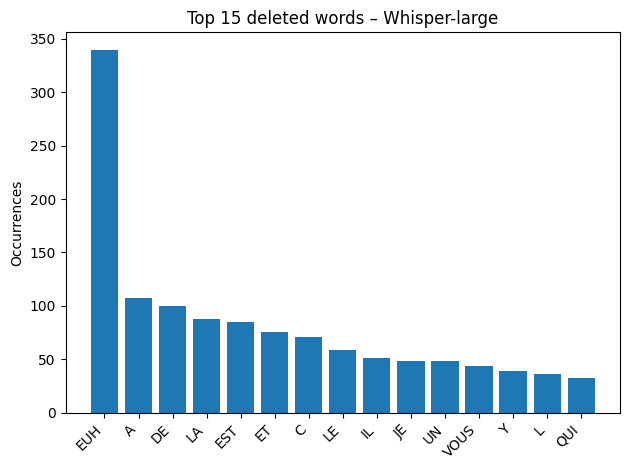

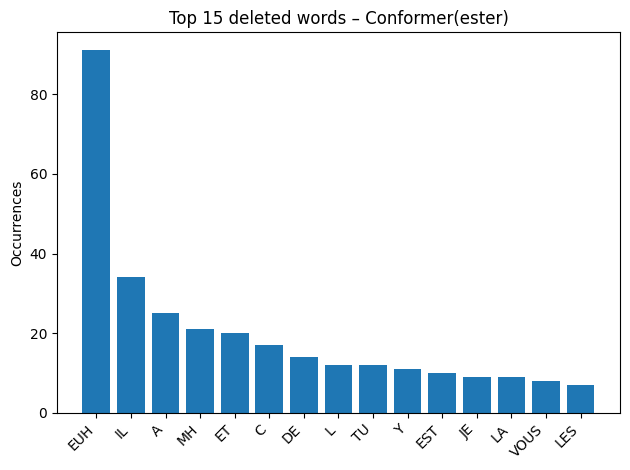

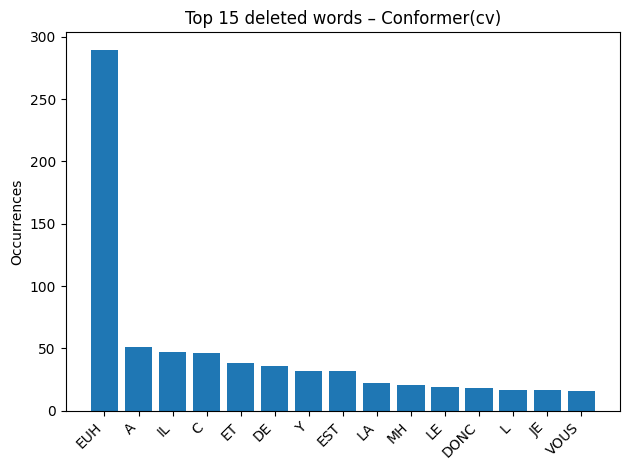

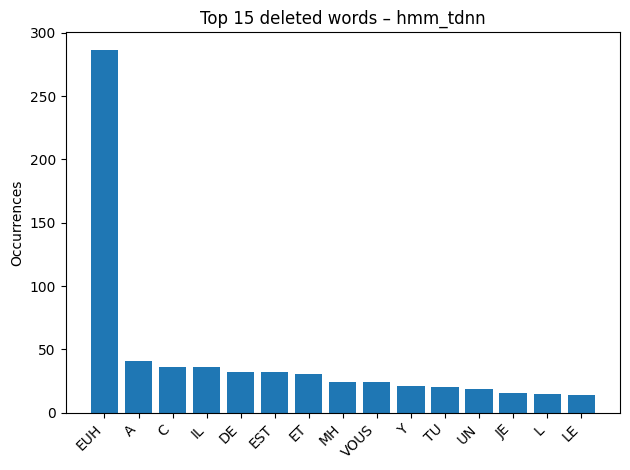

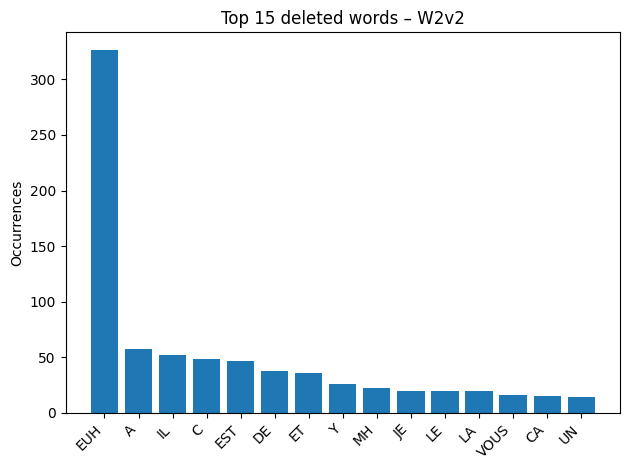

In [200]:

for asr, data in results.items():
    plot_top_deleted(
        del_dict=data["deleted"],
        asr_name=asr,
        top_n=15
    )


In [201]:
results = {
    "Whisper-large": {
        "deleted": del_dict_whisp_large,
        "euh_subs": euh_subs_whisp_large
    },
    "Whisper": {
        "deleted": del_dict_whisp,
        "euh_subs": euh_subs_whisp
    },
    "Conformer(ester)": {
        "deleted": del_dict_conf,
        "euh_subs": euh_subs_conf
    }
    ,
    "Conformer(cv)": {
        "deleted": del_dict_confcv,
        "euh_subs": euh_subs_confcv
    }
    ,
    "hmm_tdnn": {
        "deleted": del_dict_hmm,
        "euh_subs": euh_subs_hmm
    }
    ,
    "W2v2": {
        "deleted": del_dict_w2v,
        "euh_subs": euh_subs_w2v
    }
}

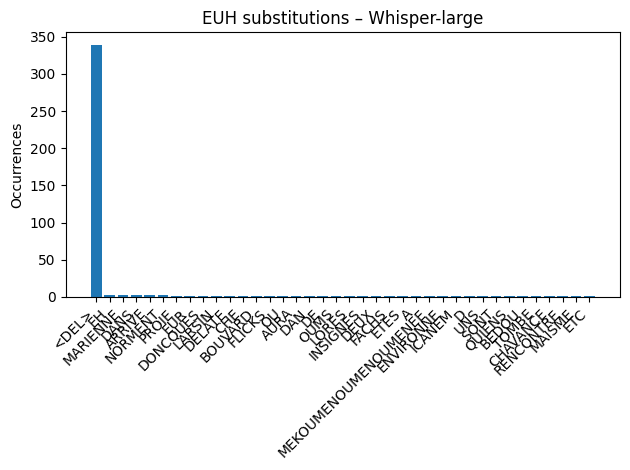

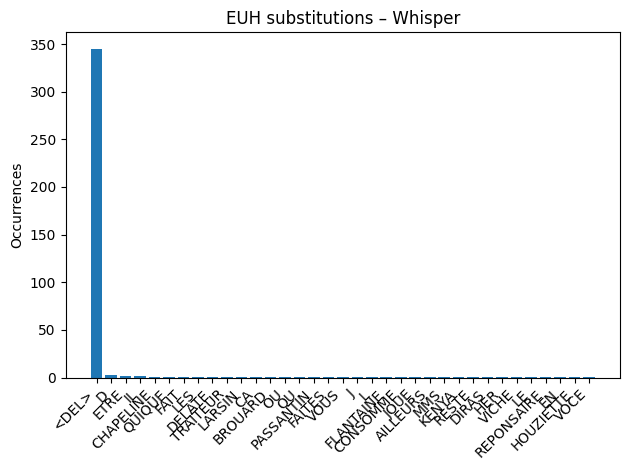

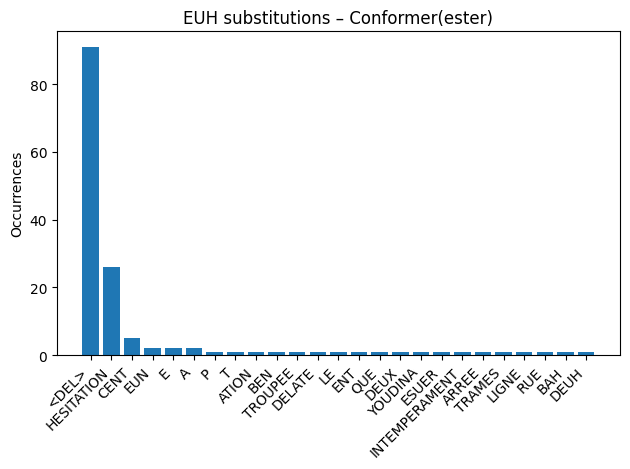

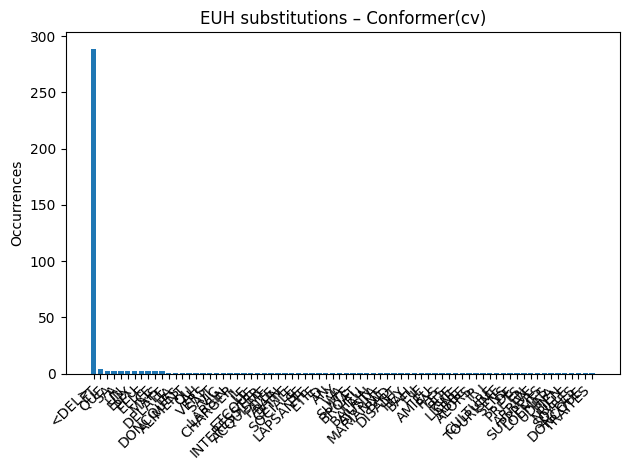

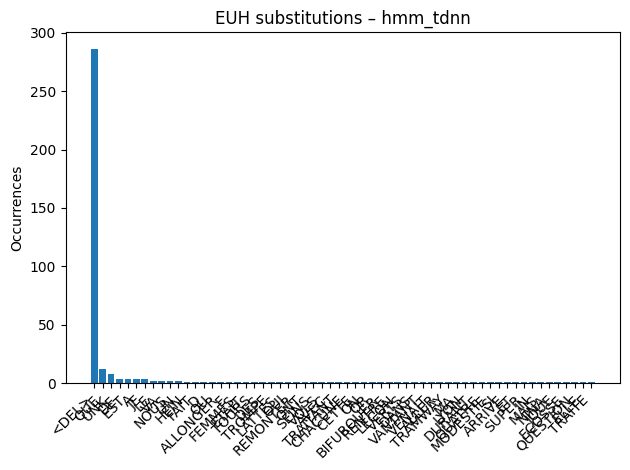

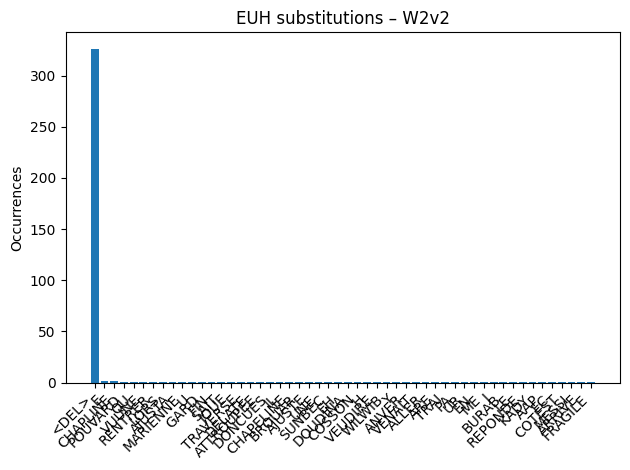

In [202]:
for asr, data in results.items():
    plot_euh_replacements(
        euh_dict=data["euh_subs"],
        asr_name=asr
    )


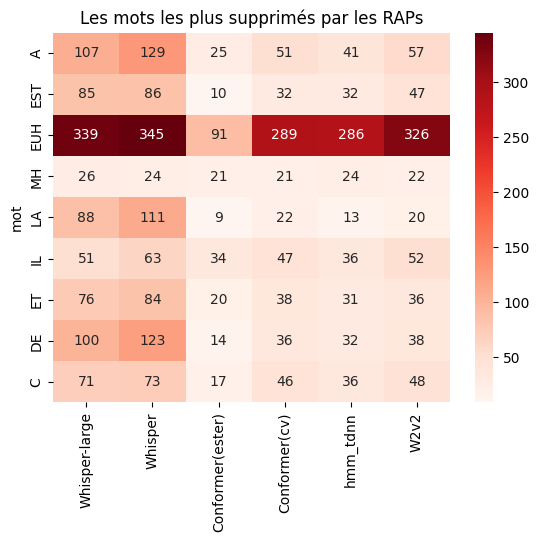

In [215]:
import seaborn as sns
del_by_asr = {
    asr: data["deleted"]
    for asr, data in results.items()
}
heatmap_deleted_words(del_by_asr, top_n=5)

In [206]:
import pandas as pd

rows = []
for asr, data in results.items():
    for repl, count in data["euh_subs"].items():
        rows.append({
            "asr": asr,
            "replacement": repl,
            "count": count
        })

df = pd.DataFrame(rows)


In [207]:
top_repl = (
    df.groupby("replacement")["count"]
      .sum()
      .sort_values(ascending=False)
      .head(6)
      .index
)

df = df[df["replacement"].isin(top_repl)]


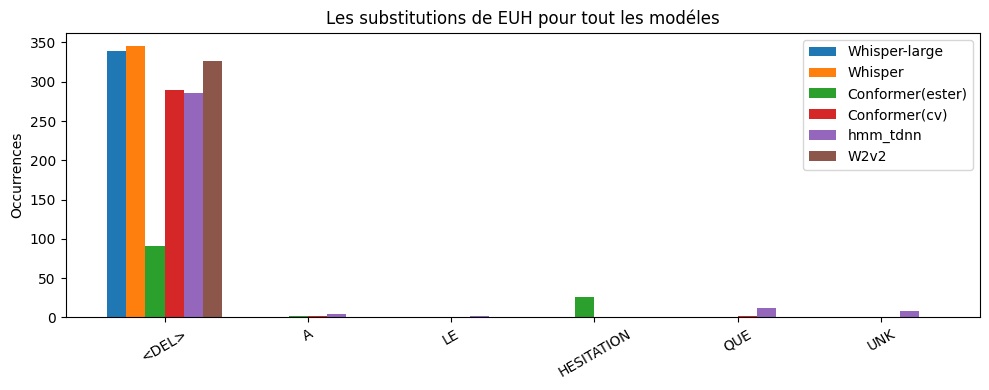

In [213]:
import matplotlib.pyplot as plt
import numpy as np

repls = df["replacement"].unique()
asrs = df["asr"].unique()

x = np.arange(len(repls))
width = 0.8 / len(asrs)

plt.figure(figsize=(10, 4))

for i, asr in enumerate(asrs):
    vals = [
        df[(df["asr"] == asr) & (df["replacement"] == r)]["count"].sum()
        for r in repls
    ]
    plt.bar(x + i*width, vals, width, label=asr)

plt.xticks(x + width*(len(asrs)-1)/2, repls, rotation=30)
plt.ylabel("Occurrences")
plt.title("Les substitutions de EUH pour tout les modéles")
plt.legend()
plt.tight_layout()
plt.savefig("subs_euh.png")
plt.show()


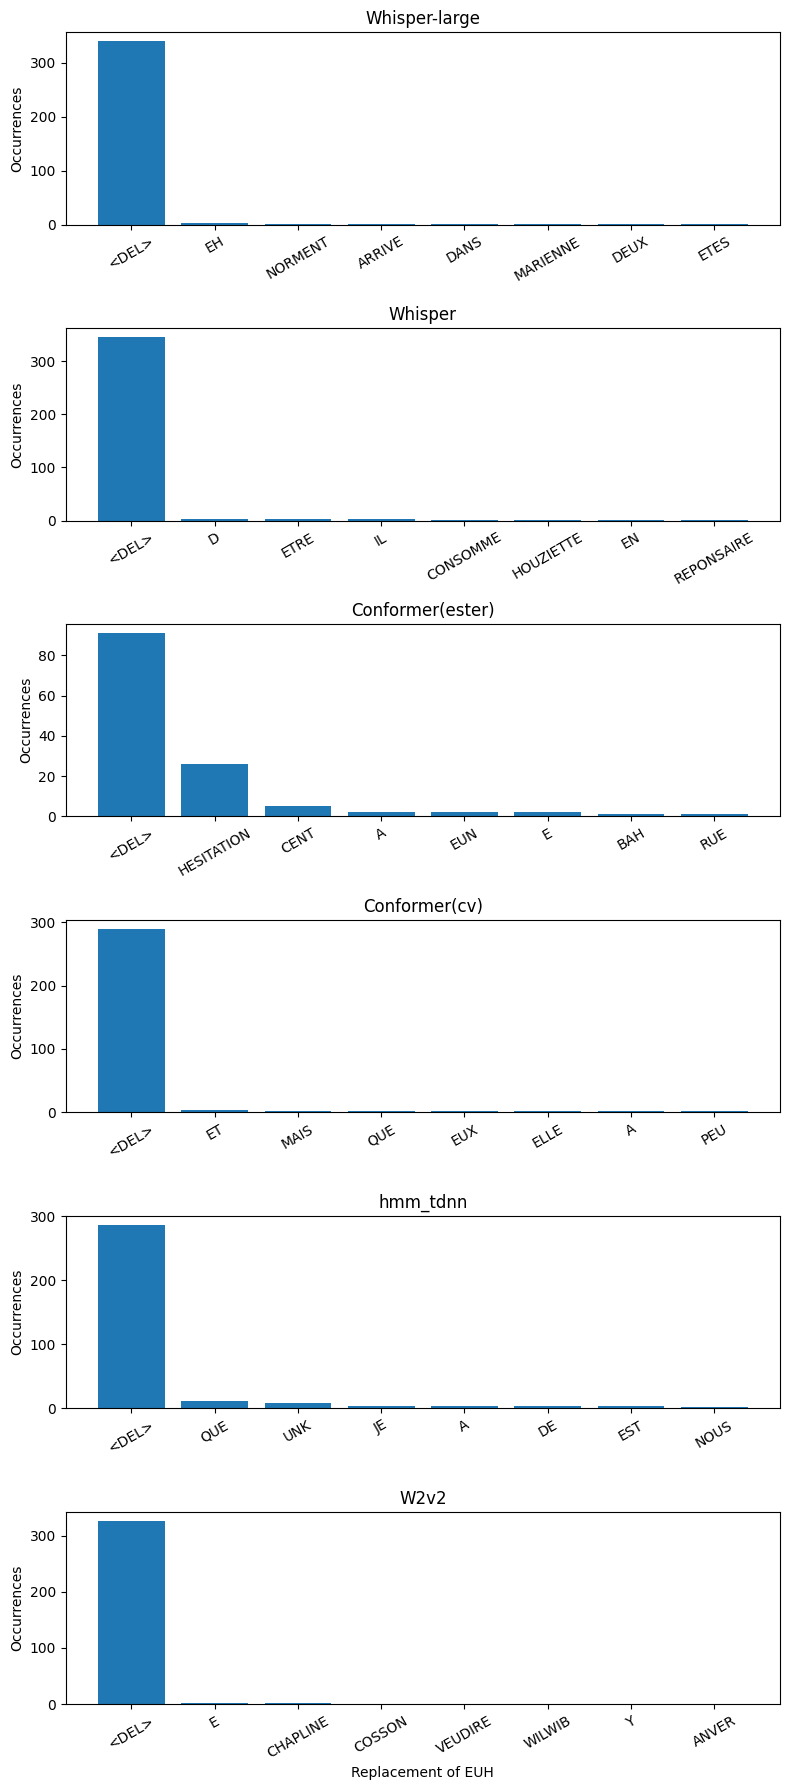

In [216]:
import matplotlib.pyplot as plt

n = len(results)
fig, axes = plt.subplots(n, 1, figsize=(8, 3*n), sharex=False)

if n == 1:
    axes = [axes]

for ax, (asr, data) in zip(axes, results.items()):
    euh_dict = data["euh_subs"]

    # garder top-N pour lisibilité
    euh_dict = dict(
        sorted(euh_dict.items(), key=lambda x: x[1], reverse=True)[:5]
    )

    ax.bar(euh_dict.keys(), euh_dict.values())
    ax.set_title(asr)
    ax.set_ylabel("Occurrences")
    ax.tick_params(axis="x", rotation=30)

axes[-1].set_xlabel("Replacement of EUH")
plt.tight_layout()
plt.show()


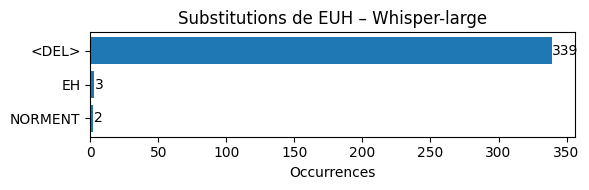

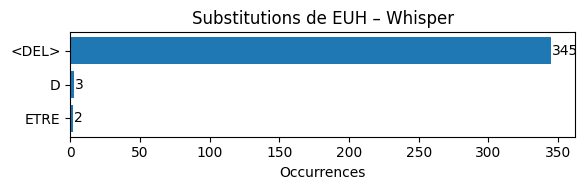

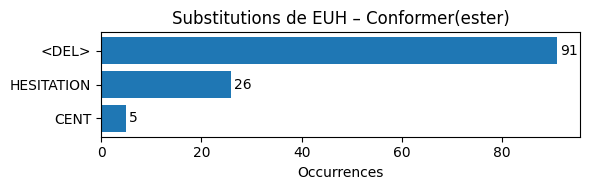

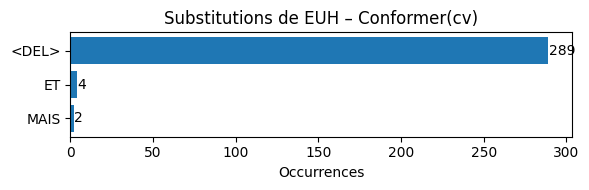

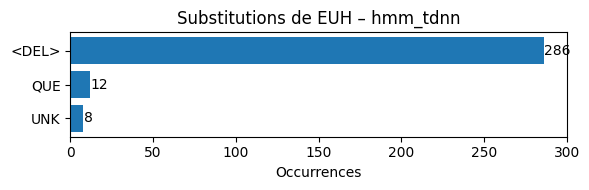

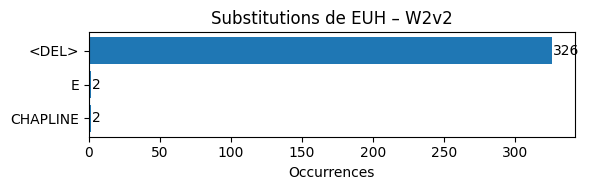

In [239]:
import matplotlib.pyplot as plt

for asr, data in results.items():
    # take EUH substitutions for this ASR
    euh_dict = data["euh_subs"]

    # keep top-N for readability
    euh_dict = dict(
        sorted(euh_dict.items(), key=lambda x: x[1], reverse=True)[:3]
    )

    words = list(euh_dict.keys())
    values = list(euh_dict.values())

    fig, ax = plt.subplots(figsize=(6, 2))

    ax.barh(words, values)
    ax.set_title(f"Substitutions de EUH – {asr}")
    ax.set_xlabel("Occurrences")
    ax.invert_yaxis()

    # add numbers on bars
    for i, v in enumerate(values):
        ax.text(v + 0.5, i, str(v), va="center")

    plt.tight_layout()
    plt.savefig(f"/vol/experiments3/imbenamor/TAPAS-FRAIS/figures/sub_euh_{asr}.png")
    plt.show()


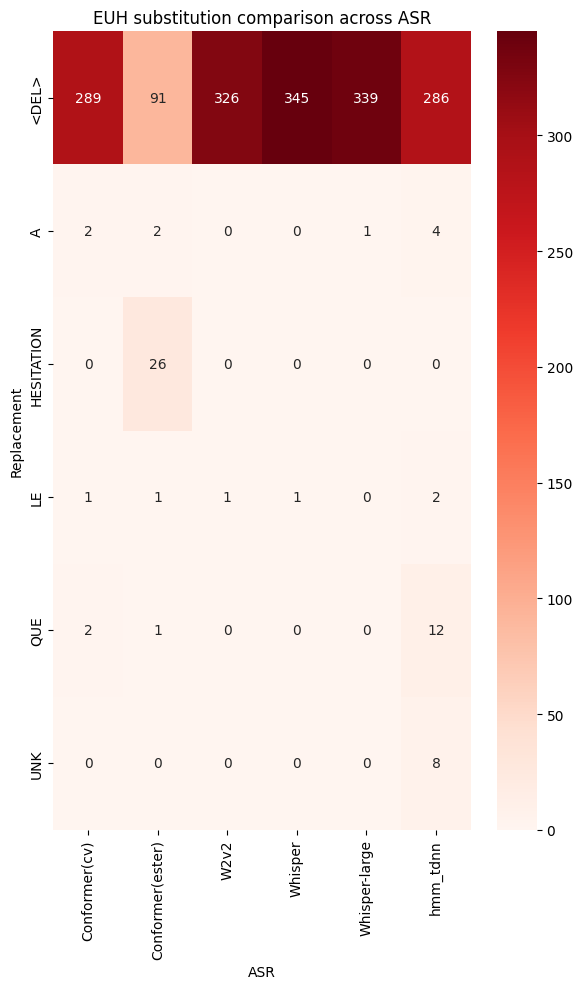

In [211]:
pivot = df.pivot_table(
    index="replacement",
    columns="asr",
    values="count",
    fill_value=0
)

import seaborn as sns

plt.figure(figsize=(6, 10))
sns.heatmap(pivot, annot=True, fmt="d", cmap="Reds")
plt.title("EUH substitution comparison across ASR")
plt.ylabel("Replacement")
plt.xlabel("ASR")
plt.tight_layout()
plt.show()


In [190]:
tmp=pd.DataFrame(del_by_asr).iloc[:20,:]
tmp = tmp/tmp.max()

In [191]:
tmp

,Whisper-large,Conformer(ester),Conformer(cv),hmm_tdnn,W2v2
EUH,1.000000,1.000000,1.000000,1.000000,1.000000
A,0.315634,0.274725,0.176471,0.143357,0.174847
DE,0.294985,0.153846,0.124567,0.111888,0.116564
LA,0.259587,0.098901,0.076125,0.045455,0.061350
EST,0.250737,0.109890,0.110727,0.111888,0.144172
ET,0.224189,0.219780,0.131488,0.108392,0.110429
C,0.209440,0.186813,0.159170,0.125874,0.147239
LE,0.174041,0.054945,0.065744,0.048951,0.061350
IL,0.150442,0.373626,0.162630,0.125874,0.159509
JE,0.141593,0.098901,0.058824,0.055944,0.061350


In [41]:
import re
import csv
import sys
from pathlib import Path
import os

# Regex to match lines like:
# File: CCM-002710-01_L01.wav | WER=74.874372 | S=80 D=60 I=9
PATTERN = re.compile(
    r"File:\s+(?P<file>\S+)\s+\|\s+"
    r"WER=(?P<wer>[0-9.]+)\s+\|\s+"
    r"S=(?P<s>\d+)\s+D=(?P<d>\d+)\s+I=(?P<i>\d+)"
)

def extract_metrics(log_path, output_csv):
    rows = []

    with open(log_path, "r", encoding="utf-8") as f:
        for line in f:
            match = PATTERN.search(line)
            if match:
                rows.append({
                    "file": match.group("file"),
                    "WER": float(match.group("wer")),
                    "S": int(match.group("s")),
                    "D": int(match.group("d")),
                    "I": int(match.group("i")),
                })

    if not rows:
        print(" No matching lines found in the log.")
        return

    with open(output_csv, "w", newline="", encoding="utf-8") as csvfile:
        writer = csv.DictWriter(
            csvfile,
            fieldnames=["file", "WER", "S", "D", "I"]
        )
        writer.writeheader()
        writer.writerows(rows)

    print(f"✅ Extracted {len(rows)} entries into {output_csv}")

extract_metrics("/vol/experiments3/imbenamor/TAPAS-FRAIS/logs/whisper_CEREB_vad_chunk.log", "/vol/experiments3/imbenamor/TAPAS-FRAIS/logs/csv_files/typaloc/whisper_cereb_vad_chunk.csv")

✅ Extracted 7 entries into /vol/experiments3/imbenamor/TAPAS-FRAIS/logs/csv_files/typaloc/whisper_cereb_vad_chunk.csv


In [67]:
"""df = pd.read_csv("/vol/experiments3/imbenamor/TAPAS-FRAIS/logs/csv_files/typaloc/CEREB_conf_rvad.csv")
df["model"] = ["Conformer(cv)"]*len(df)
df["vad"] = ["rvad"]*len(df)
df1 = pd.read_csv("/vol/experiments3/imbenamor/TAPAS-FRAIS/logs/csv_files/typaloc/CEREB_conf_rvad_ester.csv")
df1["model"] = ["Conformer(ester)"]*len(df1)
df1["vad"] = ["rvad"]*len(df1)
df2 = pd.read_csv("/vol/experiments3/imbenamor/TAPAS-FRAIS/logs/csv_files/typaloc/hmm_tdnn_CEREB.csv")
df2["model"] = ["HMM_TDNN"]*len(df1)
df2["vad"] = ["None"]*len(df1)
df3 = pd.read_csv("/vol/experiments3/imbenamor/TAPAS-FRAIS/logs/csv_files/typaloc/CEREB_w2v2.csv")
df3["model"] = ["W2V2"]*len(df1)
df3["vad"] = ["None"]*len(df1)
df4 = pd.read_csv("/vol/experiments3/imbenamor/TAPAS-FRAIS/logs/csv_files/typaloc/wer_whisper_large-VAD-chunk_CEREB_rvad.csv")
df4["model"] = ["Whisper-large"]*len(df1)
df4["vad"] = ["rvad"]*len(df1)
df5 = pd.read_csv("/vol/experiments3/imbenamor/TAPAS-FRAIS/logs/csv_files/typaloc/wer_typaloc_CEREB_whisper-VAD-chunk_rvad.csv")
df5["model"] = ["Whisper-medium"]*len(df1)
df5["vad"] = ["rvad"]*len(df1)
df_final1 = pd.concat([df, df1,df2,df3,df4,df5], axis=0, ignore_index=True)"""

In [68]:
"""df = pd.read_csv("/vol/experiments3/imbenamor/TAPAS-FRAIS/logs/csv_files/typaloc/CEREB_conf_silero.csv")
df["model"] = ["Conformer(cv)"]*len(df)
df["vad"] = ["silero"]*len(df)
df1 = pd.read_csv("/vol/experiments3/imbenamor/TAPAS-FRAIS/logs/csv_files/typaloc/CEREB_conf_silero_ester.csv")
df1["model"] = ["Conformer(ester)"]*len(df1)
df1["vad"] = ["silero"]*len(df1)
df2 = pd.read_csv("/vol/experiments3/imbenamor/TAPAS-FRAIS/logs/csv_files/typaloc/hmm_tdnn_CEREB.csv")
df2["model"] = ["HMM_TDNN"]*len(df1)
df2["vad"] = ["None"]*len(df1)
df3 = pd.read_csv("/vol/experiments3/imbenamor/TAPAS-FRAIS/logs/csv_files/typaloc/CEREB_w2v2.csv")
df3["model"] = ["W2V2"]*len(df1)
df3["vad"] = ["None"]*len(df1)
df4 = pd.read_csv("/vol/experiments3/imbenamor/TAPAS-FRAIS/logs/csv_files/typaloc/wer_whisper_large-VAD-chunk_CEREB_silero.csv")
df4["model"] = ["Whisper-large"]*len(df1)
df4["vad"] = ["silero"]*len(df1)
df5 = pd.read_csv("/vol/experiments3/imbenamor/TAPAS-FRAIS/logs/csv_files/typaloc/wer_typaloc_CEREB_whisper-VAD-chunk_silero.csv")
df5["model"] = ["Whisper-medium"]*len(df1)
df5["vad"] = ["silero"]*len(df1)
df_final2 = pd.concat([df, df1,df2,df3,df4,df5], axis=0, ignore_index=True)"""

In [63]:
"""df = pd.read_csv("/vol/experiments3/imbenamor/TAPAS-FRAIS/logs/csv_files/tapas/conf_tapas_rvad.csv")
df["model"] = ["Conformer(cv)"]*len(df)
df["vad"] = ["rvad"]*len(df)
df1 = pd.read_csv("/vol/experiments3/imbenamor/TAPAS-FRAIS/logs/csv_files/tapas/tapas_conf_ester_rvad.csv")
df1["model"] = ["Conformer(ester)"]*len(df1)
df1["vad"] = ["rvad"]*len(df1)
df2 = pd.read_csv("/vol/experiments3/imbenamor/TAPAS-FRAIS/logs/csv_files/tapas/hmm_tdnn_tapas.csv")
df2["model"] = ["HMM_TDNN"]*len(df1)
df2["vad"] = ["None"]*len(df1)
df3 = pd.read_csv("/vol/experiments3/imbenamor/TAPAS-FRAIS/logs/csv_files/tapas/w2v_tapas.csv")
df3["model"] = ["W2V2"]*len(df1)
df3["vad"] = ["None"]*len(df1)
df4 = pd.read_csv("/vol/experiments3/imbenamor/TAPAS-FRAIS/logs/csv_files/tapas/whisper_large_vad_chunk_tapas_rvad.csv")
df4["model"] = ["Whisper-large"]*len(df1)
df4["vad"] = ["rvad"]*len(df1)
df5 = pd.read_csv("/vol/experiments3/imbenamor/TAPAS-FRAIS/logs/csv_files/tapas/whisper_vad_chunk_tapas_rvad.csv")
df5["model"] = ["Whisper-medium"]*len(df1)
df5["vad"] = ["rvad"]*len(df1)
df_final1 = pd.concat([df, df1,df2,df3,df4,df5], axis=0, ignore_index=True)"""

In [64]:
"""df = pd.read_csv("/vol/experiments3/imbenamor/TAPAS-FRAIS/logs/csv_files/tapas/conf_tapas_silero.csv")
df["model"] = ["Conformer(cv)"]*len(df)
df["vad"] = ["silero"]*len(df)
df1 = pd.read_csv("/vol/experiments3/imbenamor/TAPAS-FRAIS/logs/csv_files/tapas/tapas_conf_ester_silero.csv")
df1["model"] = ["Conformer(ester)"]*len(df1)
df1["vad"] = ["silero"]*len(df1)
df2 = pd.read_csv("/vol/experiments3/imbenamor/TAPAS-FRAIS/logs/csv_files/tapas/hmm_tdnn_tapas.csv")
df2["model"] = ["HMM_TDNN"]*len(df1)
df2["vad"] = ["None"]*len(df1)
df3 = pd.read_csv("/vol/experiments3/imbenamor/TAPAS-FRAIS/logs/csv_files/tapas/w2v_tapas.csv")
df3["model"] = ["W2V2"]*len(df1)
df3["vad"] = ["None"]*len(df1)
df4 = pd.read_csv("/vol/experiments3/imbenamor/TAPAS-FRAIS/logs/csv_files/tapas/whisper_large_vad_chunk_tapas_silero.csv")
df4["model"] = ["Whisper-large"]*len(df1)
df4["vad"] = ["silero"]*len(df1)
df5 = pd.read_csv("/vol/experiments3/imbenamor/TAPAS-FRAIS/logs/csv_files/tapas/whisper_vad_chunk_tapas_silero.csv")
df5["model"] = ["Whisper-medium"]*len(df1)
df5["vad"] = ["silero"]*len(df1)
df_final2 = pd.concat([df, df1,df2,df3,df4,df5], axis=0, ignore_index=True)"""

In [70]:
#df = pd.concat([df_final1,df_final2], axis=0, ignore_index=True)

/tmp/ipykernel_3578902/3002393606.py:14: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(


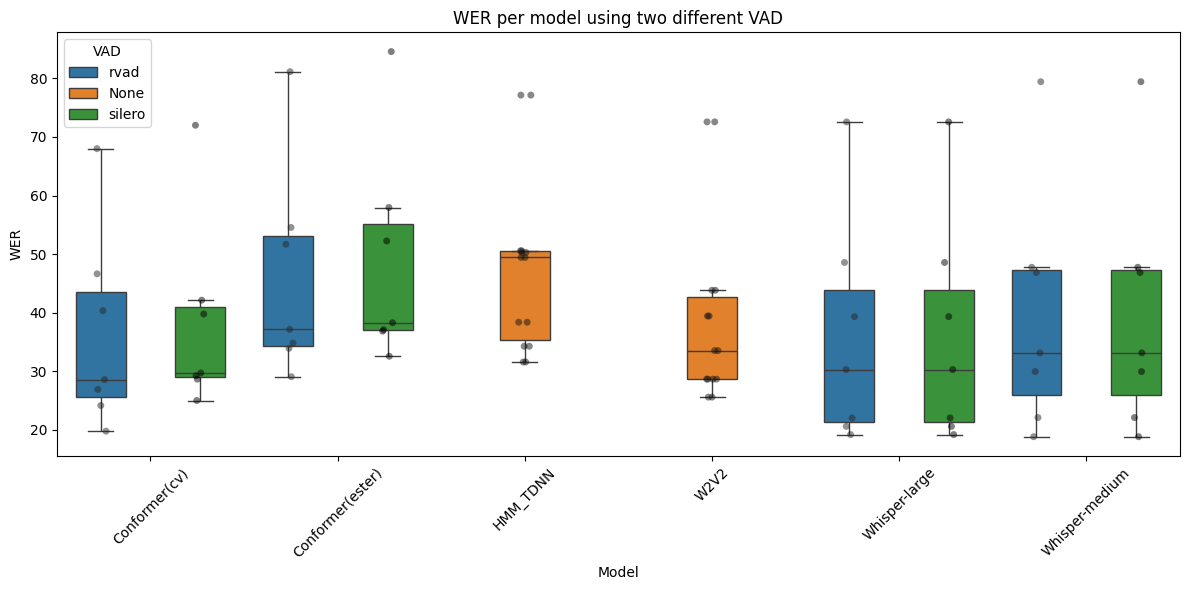

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

sns.boxplot(
    data=df,
    x="model",
    y="WER",
    hue="vad",
    showfliers=False
)

sns.stripplot(
    data=df,
    x="model",
    y="WER",
    hue="vad",
    dodge=True,      # IMPORTANT pour séparer les points
    alpha=0.5,
    color="black"
)

plt.ylabel("WER")
plt.xlabel("Model")
plt.title("WER per model using two different VAD")
plt.xticks(rotation=45)

# ⚠️ éviter la double légende
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[:len(set(df.vad))], labels[:len(set(df.vad))], title="VAD")

plt.tight_layout()
plt.savefig("/vol/experiments3/imbenamor/TAPAS-FRAIS/figures/wer_CEREB_plot.png")
plt.show()


In [ ]:
# Ajouter la colonne label
df1["VAD"] = "rvad"
df2["VAD"] = "silero"

# Fusionner (empiler les lignes)
df_final = pd.concat([df1, df2], axis=0, ignore_index=True)

#df_final.to_csv("/vol/experiments3/imbenamor/TAPAS-FRAIS/logs/csv_files/conf_ester_rhap.csv")


In [23]:
path= "/vol/experiments3/imbenamor/TAPAS-FRAIS/logs/csv_files/typaloc"
csv_files =["w2v_rhap_vad_chunk.csv","whisper_vad-chunk_rhap_rvad.csv","whisper_large-vad-chunk_rhap_rvad.csv","confcv_rhap_vad_chunk.csv","conf_ester_rhap_vad_chunk.csv","hmm_tdnn_rhap_vad_chunk.csv"]
labels = ["W2v2","Whisper-med","whisper-large","Conformer(cv)","Conformer(ester)","Hmm-Tdnn"]
wer_data = []
for ids,f in enumerate(csv_files):
    d=f"Data {ids}"
    d=pd.read_csv(os.path.join(path,f))
    wer_data.append(d["WER"].dropna())

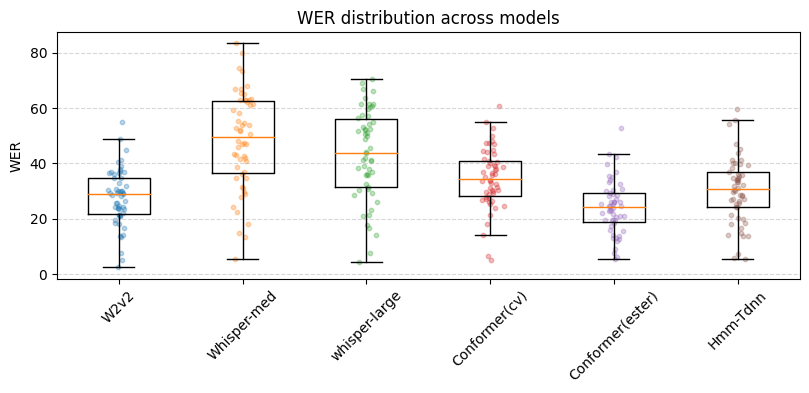

In [24]:
plt.figure(figsize=(8, 3))

# Boxplot
plt.boxplot(wer_data, labels=labels, showfliers=False)

# Overlay data points
for i, values in enumerate(wer_data, start=1):
    x = np.random.normal(i, 0.04, size=len(values))  # jitter
    plt.scatter(x, values, alpha=0.3, s=10)
plt.tight_layout()
plt.ylabel("WER")
plt.xticks(rotation=45)
plt.title("WER distribution across models")
plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.savefig("/vol/experiments3/imbenamor/TAPAS-FRAIS/figures/wer_rhap_plot.png")
plt.show()


In [10]:
#csv_files=["/vol/experiments3/imbenamor/TAPAS-FRAIS/logs/csv_files/wer_tapas_verified.csv","/vol/experiments3/imbenamor/TAPAS-FRAIS/logs/csv_files/whisper_tapas_verif_vad_chunk.csv","/vol/experiments3/imbenamor/TAPAS-FRAIS/logs/csv_files/wer_whisper_large-tapas.csv","/vol/experiments3/imbenamor/TAPAS-FRAIS/logs/csv_files/wer_tapas_vad_whisper_medium.csv","/vol/experiments3/imbenamor/TAPAS-FRAIS/logs/csv_files/wer_tapas_whisper_medium.csv","/vol/experiments3/imbenamor/TAPAS-FRAIS/logs/csv_files/wer_tapas_hmm_tdnn_rouas.csv","/vol/experiments3/imbenamor/TAPAS-FRAIS/logs/csv_files/wer_tapas_conf_ester_rouas.csv","/vol/experiments3/imbenamor/TAPAS-FRAIS/logs/csv_files/wer_tapas_conf_cv_rouas.csv"]
#labels = ["Wav2vec", "Whisper-VAD-chunk","Whisper-large-VAD-chunk","Whisper-VAD","Whisper-medium","HMM-TDNN","Conformer(ester)","Conformer(CV)"]
#csv_files=["/vol/experiments3/imbenamor/TAPAS-FRAIS/logs/csv_files/wer_rhap.csv","/vol/experiments3/imbenamor/TAPAS-FRAIS/logs/csv_files/wer_rhap_whisper_medium.csv","/vol/experiments3/imbenamor/TAPAS-FRAIS/logs/csv_files/whisper_rhap_vad_chunk.csv","/vol/experiments3/imbenamor/TAPAS-FRAIS/logs/csv_files/wer_whisper_large-vad-chunk_rhap.csv","/vol/experiments3/imbenamor/TAPAS-FRAIS/logs/csv_files/wer_hmm_tdnn_rouas.csv","/vol/experiments3/imbenamor/TAPAS-FRAIS/logs/csv_files/wer_rhap_conformer_rouas.csv"]
#labels =["wav2vec","Whisper-medium","Whisper-VAD-chunk","Whisper-large-VAD-chunk","Hmm-TDNN(ester)","Conformer(ester)"]
#csv_files = ["/vol/experiments3/imbenamor/TAPAS-FRAIS/logs/csv_£files/wer_typaloc_CEREB_wav2vec.csv",""]
#labels = ["CEREB"]
path= "/vol/experiments3/imbenamor/TAPAS-FRAIS/logs/csv_files/tapas"
csv_files =["w2v2_tapas_vad_chunk.csv","whisper_vad_chunk_tapas_rvad.csv","whisper_large_vad_chunk_tapas_rvad.csv","confcv_tapas_vad_chunk.csv","confester_tapas_vad_chunk.csv","hmm_tdnn_tapas_vad_chunk.csv"]
labels = ["W2v2","Whisper-med","whisper-large","Conformer(cv)","Conformer(ester)","Hmm-Tdnn"]
wer_data = []
for ids,f in enumerate(csv_files):
    d=f"Data {ids}"
    d=pd.read_csv(os.path.join(path,f))
    wer_data.append(d["WER"].dropna())

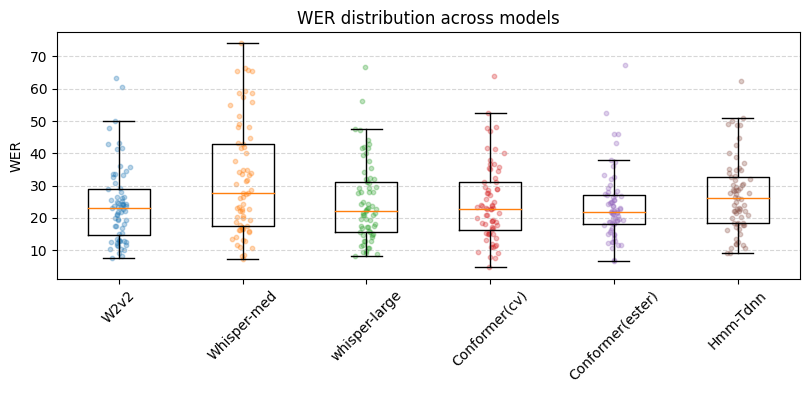

In [18]:
plt.figure(figsize=(8, 3))

# Boxplot
plt.boxplot(wer_data, labels=labels, showfliers=False)

# Overlay data points
for i, values in enumerate(wer_data, start=1):
    x = np.random.normal(i, 0.04, size=len(values))  # jitter
    plt.scatter(x, values, alpha=0.3, s=10)
plt.tight_layout()
plt.ylabel("WER")
plt.xticks(rotation=45)
plt.title("WER distribution across models")
plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.savefig("/vol/experiments3/imbenamor/TAPAS-FRAIS/figures/wer_tapas_plot.png")
plt.show()


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

experiments = ["W2V2", "Whisper-med","Whisper-large","Conformer(cv)","Conformer(ester)","Hmm_tdnn"]
datasets = ["CEREB", "PARK", "SLA", "CTR"]
folder_path="/vol/experiments3/imbenamor/TAPAS-FRAIS/logs/csv_files/typaloc/"
files = {
    "W2V2": [folder_path+"w2v_cereb_vad_chunk.csv", folder_path+"w2v_park_vad_chunk.csv", folder_path+"w2v_SLA_vad_chunk.csv", folder_path+"w2v_ctrl_vad_chunk.csv"],
    "Whisper-med": [folder_path+"whisper_cereb_vad_chunk.csv",folder_path+"whisper_PARK_VAD_chunk_rvad.csv",folder_path+"whisper_SLA_vad_chunk_rvad.csv",folder_path+"whisper_vad_chunk_CTRL_rvad.csv"],
    "Whisper-large":[folder_path+"wer_whisper_large-VAD-chunk_CEREB_rvad.csv",folder_path+"wer_whisper_large-VAD-chunk_PARK_rvad.csv",folder_path+"wer_whisper_large-VAD-chunk_SLA_rvad.csv",folder_path+"wer_whisper_large-vad-chunk_CTRL_rvad.csv"],    
    "Conformer(cv)":[folder_path+"confcv_cereb_vad_chunk.csv",folder_path+"confcv_park_vad_chunk.csv",folder_path+"confcv_sla_vad_chunk.csv",folder_path+"confcv_ctrl_vad_chunk.csv"],
    "Conformer(ester)":[folder_path+"conf_ester_cereb_vad_chunk.csv",folder_path+"conf_ester_park_vad_chunk.csv",folder_path+"conf_ester_sla_vad_chunk.csv",folder_path+"conf_ester_ctrl_vad_chunk.csv"],
    "Hmm_tdnn":[folder_path+"hmm_tdnn_CEREB_vad_chunk.csv",folder_path+"hmm_tdnn_PARK_vad_chunk.csv",folder_path+"hmm_tdnn_SLA_vad_chunk.csv",folder_path+"hmm_tdnn_ctrl_vad_chunk.csv"]
}

# Load data
data = {}
for exp in experiments:
    data[exp] = []
    for f in files[exp]:
        df = pd.read_csv(f)
        data[exp].append(df["WER"].dropna().values)



In [32]:
big_mat.shape

(39, 6)

[[23.976608 22.59887  20.588235 23.976608 33.918129 33.333333]
 [23.595506 27.272727 19.186047 22.674419 32.58427  41.011236]
 [26.966292 32.36715  22.033898 33.146067 33.707865 31.460674]
 [29.714286 35.449735 30.285714 26.285714 33.714286 49.142857]
 [32.20339  47.668394 48.571429 35.59322  50.282486 57.062147]
 [41.573034 52.631579 39.325843 49.438202 51.685393 55.05618 ]
 [64.571429 81.642512 72.571429 63.428571 76.571429 81.714286]]
[[14.689266 24.293785 12.429379 18.079096 27.683616 24.293785]
 [19.774011 17.514124 19.774011 23.163842 27.683616 31.638418]
 [31.578947 33.333333 28.654971 41.520468 33.333333 32.163743]
 [42.372881 31.073446 32.768362 37.853107 53.107345 45.19774 ]
 [35.795455 63.068182 57.386364 36.931818 45.454545 42.045455]
 [46.857143 48.       36.571429 37.142857 62.857143 53.142857]
 [29.189189 76.271186 73.446328 56.216216 50.27027  43.243243]
 [55.357143 77.380952 61.904762 50.595238 62.5      70.833333]]
[[ 17.514124  24.712644  25.862069  18.644068  32.203

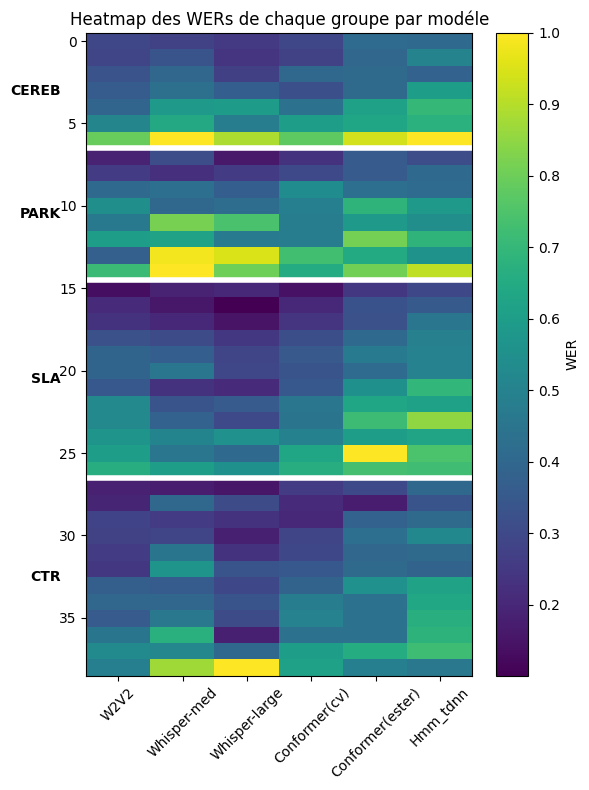

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Build one big matrix
all_rows = []
row_labels = []
dataset_boundaries = []

row_count = 0

for d_idx, dataset in enumerate(datasets):
    # matrix: samples × experiments
    mat = np.column_stack([
    data[exp][d_idx] for exp in experiments
    ])

    # 🔽 SORT HERE (low → high mean WER)
    order = np.argsort(mat.mean(axis=1))
    mat = mat[order]
    

    all_rows.append(mat)

    # labels (optional: file index)
    row_labels.extend([f"{dataset}_s{i}" for i in range(mat.shape[0])])

    row_count += mat.shape[0]
    dataset_boundaries.append(row_count)
for i,d in enumerate(all_rows):
    print(d)
    all_rows[i]=d/d.max()
# Concatenate everything
big_mat = np.vstack(all_rows)

# Plot
plt.figure(figsize=(6, 8))
im = plt.imshow(big_mat, aspect="auto", cmap="viridis")
start = 0
for d_idx, dataset in enumerate(datasets):
    n_rows = all_rows[d_idx].shape[0]
    center = start + n_rows / 2 - 0.5

    plt.text(
        -0.9, center, dataset,
        va="center", ha="right",
        fontsize=10, fontweight="bold"
    )

    start += n_rows

plt.xticks(range(len(experiments)), experiments, rotation=45)
#plt.ylabel("Groupes")
plt.title("Heatmap des WERs de chaque groupe par modéle")

# Dataset separators
for y in dataset_boundaries[:-1]:
    plt.axhline(y - 0.5, color="white", linewidth=4)

plt.colorbar(im, label="WER")
plt.savefig("/vol/experiments3/imbenamor/TAPAS-FRAIS/figures/typaloc_heatmap_normalized_group.png")

plt.tight_layout()
plt.show()


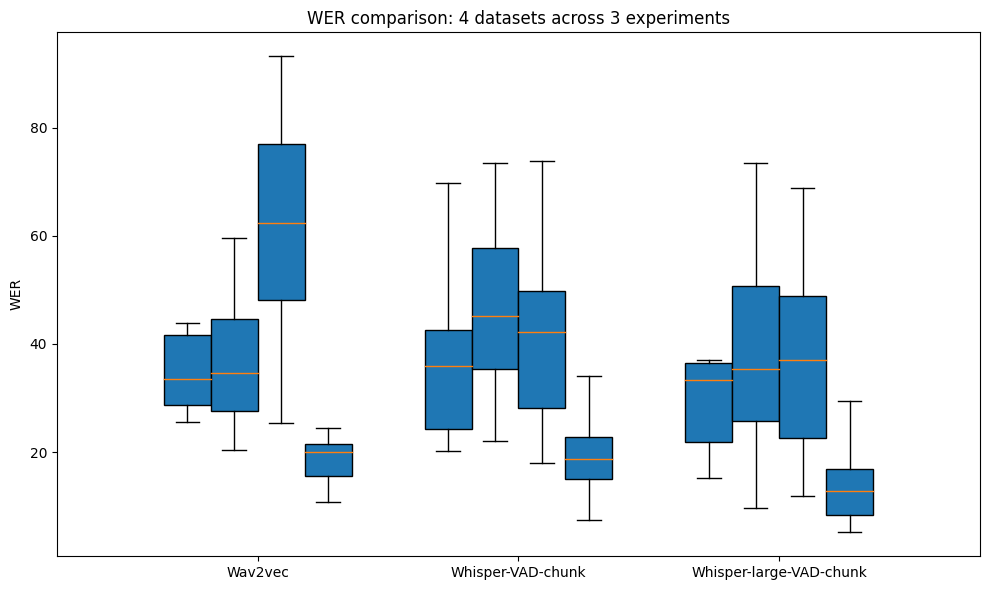

In [5]:
# Plot
plt.figure(figsize=(10, 6))

n_datasets = len(datasets)
width = 0.18
x = np.arange(len(experiments))

for i in range(n_datasets):
    plt.boxplot(
        [data[exp][i] for exp in experiments],
        positions=x + i * width,
        widths=width,
        patch_artist=True,
        showfliers=False
    )

# X-axis formatting
plt.xticks(x + width * (n_datasets - 1) / 2, experiments, rotation=0)
plt.ylabel("WER")
plt.title("WER comparison: 4 datasets across 3 experiments")

plt.tight_layout()
plt.show()
